#### Get an ODBC connection 

In [1]:
import pyodbc 
import time

server = 'irisimlsvr'
port = '1972'
database = 'USER' 
username = 'SUPERUSER' 
password = 'SYS' 
cnxn = pyodbc.connect('DRIVER={InterSystems ODBC35};SERVER='+server+';PORT='+port+';DATABASE='+database+';UID='+username+';PWD='+ password)

cnxn.setdecoding(pyodbc.SQL_CHAR, encoding='utf8')
cnxn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf8')
cnxn.setencoding(encoding='utf8')
cursor = cnxn.cursor()

####  Prepare training data, and give a model name

In [19]:
dataTable = 'BitcoinRates'
dataColumn =  'Rate'
dataColumnPredict = "PredictedRate"
modelName = "SVR_model3" # must be unique
train_size=320
test_size=-30

#### Get bitcoin rate history rates

In [4]:
# cursor.execute(f"DROP TABLE {dataTable}")
cursor.execute(f"CREATE TABLE {dataTable} ( id INT(32) AUTO_INCREMENT PRIMARY KEY, day DATE, rate FLOAT)")

In [5]:
import pandas as pd
from datetime import datetime, timedelta

rates = pd.read_csv("coin_Bitcoin.csv", sep=",")
rates['Date'] = pd.to_datetime(rates.Date)
rates['Rate'] = (rates['High']+rates['Low'])/2
del rates['SNo'], rates['Name'], rates['Symbol'], rates['High'], rates['Low'], rates['Open'], rates['Close'], rates['Volume'], rates['Marketcap']

last_year_rates = rates.loc[rates['Date'] >= datetime.today() - timedelta(days=365)]

last_year_rates.head()

,Date,Rate
2641,2020-07-22 23:59:59,9425.086202
2642,2020-07-23 23:59:59,9546.625572
2643,2020-07-24 23:59:59,9552.395478
2644,2020-07-25 23:59:59,9617.384605
2645,2020-07-26 23:59:59,9838.327434


#### Draw a chart of the bitcoin rate 

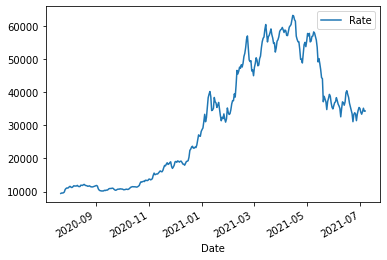

In [6]:
last_year_rates.plot.line('Date', 'Rate')

#### Insert data into IRIS

In [7]:
cursor.execute(f"TRUNCATE TABLE {dataTable}")
for index, row in last_year_rates.iterrows():
    cursor.execute(f"INSERT INTO {dataTable} VALUES ({index},'{str(row['Date'])}', {row['Rate']})")
cnxn.commit()

#### Train model and make prediction

In [13]:
cursor.execute("CREATE MODEL %s PREDICTING (%s)  FROM %s" % (modelName, dataColumn, dataTable))
cursor.execute("TRAIN MODEL %s FROM %s" % (modelName, dataTable))
cnxn.commit()
print('Model training completed')

Model training completed


In [21]:
# uncomment string if PredictedRate already exist
# cursor.execute("DROP TABLE %s" % (dataTablePredict))

#### Look at result

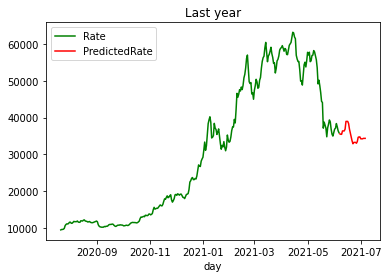

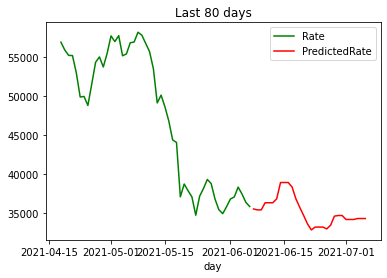

In [20]:
data = pd.read_sql("SELECT %s as Rate, day FROM %s" % (dataColumn, dataTable), cnxn)
prediction = pd.read_sql("SELECT PREDICT(%s) AS %s, day FROM %s" % (modelName, dataColumnPredict, dataTable), cnxn)
all_data = data.sort_values(by="day")[0:train_size].merge(prediction[test_size:], on="day", how="outer")
all_data.plot.line('day', color={'Rate': 'green', 'PredictedRate': 'red'}, title="Last year")
all_data[-80:].plot.line('day', color={'Rate': 'green', 'PredictedRate': 'red'}, title="Last 80 days")

#### Check model accuracy

When training the model, the accuracy is considered satisfactory if the value is greater than 95%.

In [17]:
result = pd.read_sql("SELECT PREDICT(%s) AS %s, %s as Rate, day FROM %s" % (modelName, dataColumnPredict, dataColumn, dataTable), cnxn)
result['Deviation'] = abs(result['Rate'].astype(float) - result['PredictedRate'].astype(float))/result['Rate'].astype(float)
mape = result['Deviation'].sum()*100/result['Deviation'].count()
accuracy = 100-mape
accuracy


98.51789764879966

In [3]:
cnxn.close()